In [1]:
import os
import pandas as pd
import numpy as np

from sklearn.metrics import log_loss, roc_auc_score, roc_curve, make_scorer, brier_score_loss
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from skopt import BayesSearchCV
from skopt.space import Real, Integer

from joblib import dump, load
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_regression

import warnings
warnings.filterwarnings('ignore')

In [2]:
def mcfadden_r2(y, y_pred):
    ll = log_loss(y, y_pred)
    ll_null = log_loss(y, np.full(len(y), y.mean()))
    return 1 - (ll/ll_null)
pseudo_r2_scorer = make_scorer(mcfadden_r2, needs_proba=True, greater_is_better=True)
scoring = {'roc_aug': 'roc_auc', 'mcfaddens_r2': pseudo_r2_scorer}

In [3]:
cwd = os.getcwd()
df = pd.read_parquet(os.path.join(cwd, 'data', 'shots.parquet'))
df.drop(['match_id', 'statsbomb_id', 'statsbomb_team_id', 'player_id_statsbomb', 'competition_gender', 'team_name',
         'player_id', 'firstName', 'middleName', 'lastName', 'Name', 'dataset', 'wyscout_id', 'wyscout_team_id', 'team_id',
         'player_id_wyscout','competition_name','minute','shot_zone','match_week','pass_end_y',
         'goalkeeper_x', 'goalkeeper_y', 'carry_length', 'shot_one_on_one', 'shot_open_goal','under_pressure', 'area_shot', 
         'area_goal', 'n_angle', 'smart_pass','pass_end_x'], axis=1, inplace=True)
mask_penalty = (df.shot_type_name=='penalty')
df_penalty = df[mask_penalty].copy()
df_penalty.drop(['x','y','visible_angle','middle_angle','distance_to_goal','distance_visible_angle','log_distance_to_goal',
                 'assist_type', 'pass_switch', 'pass_cross', 'pass_cut_back','counter_attack', 'pass_height_name',
                 'pass_technique_name', 'shot_zone_number','shot_zone_player_number','fast_break', 'strong_foot',
                 'body_part_name','shot_type_name'], axis=1, inplace=True)

In [4]:
df_p = pd.get_dummies(df_penalty, columns=['competition_type','competition_part','H_A_column','match_moment'])
y_p = df_p['goal']
x_p = df_p.drop(['goal'], axis=1)
x_p_train, x_p_test, y_p_train, y_p_test = train_test_split(x_p, y_p, test_size=0.2, random_state=42, stratify=y_p)

In [5]:
print('Shots penalty train', len(y_p_train), ';Number goals', y_p_train.sum(),
      ';Goals %: ', round(y_p_train.mean()*100, 1))
print('Shots penalty test', len(y_p_test), ';Number goals', y_p_test.sum(),
      ';Goals %: ', round(y_p_test.mean()*100, 1))

Shots penalty train 656 ;Number goals 486 ;Goals %:  74.1
Shots penalty test 165 ;Number goals 122 ;Goals %:  73.9


In [6]:
logreg = LogisticRegression(solver='liblinear', n_jobs=-1, max_iter=100, random_state=42)
rfe_p = RFE(logreg, 10)
rfe_p = rfe_p.fit(x_p_train, y_p_train)

x_p_train = x_p_train.loc[:, rfe_p.support_]
x_p_test = x_p_test.loc[:, rfe_p.support_]

In [7]:
sc = StandardScaler()
x_p_train_sc = sc.fit_transform(x_p_train)
x_p_test_sc = sc.fit_transform(x_p_test)

In [8]:
lr = LogisticRegression(random_state=42, solver='liblinear', max_iter=100, n_jobs=-1)

In [9]:
grid={"C": np.logspace(-3,3,7)}

In [10]:
logistic_regression_p = GridSearchCV(estimator=lr, param_grid=grid, scoring='neg_log_loss', n_jobs=-1)
%time logistic_regression_p.fit(x_p_train_sc, y_p_train)
train_y_p_hat = logistic_regression_p.predict_proba(x_p_train_sc.astype(float))
y_pred_lr_p = logistic_regression_p.predict_proba(x_p_test_sc.astype(float))

Wall time: 29.4 s


In [11]:
naive_train_log_loss_p = log_loss(y_p_train, train_y_p_hat[:,1])
naive_train_roc_auc_p = roc_auc_score(y_p_train, train_y_p_hat[:,1])
print('The log loss of our penalty model on the training set is : ' +str(round(naive_train_log_loss_p, 4)))
print('The ROC AUC of our penalty model on the training set is : ' +str(round(naive_train_roc_auc_p, 4)))
print("McFadden's Pseudo R-squared penaltys : "  +str(round( mcfadden_r2(y_p_train, train_y_p_hat), 4)))

The log loss of our penalty model on the training set is : 0.566
The ROC AUC of our penalty model on the training set is : 0.5803
McFadden's Pseudo R-squared penaltys : 0.0107


In [12]:
freg=f_regression(x_p_train_sc, y_p_train)
p=freg[1]
print(p.round(3))

[0.372 0.184 0.636 0.326 0.309 0.243 0.638 0.476 0.284 0.408]


In [13]:
logreg = LogisticRegression(solver='liblinear', n_jobs=-1, max_iter=100, random_state=42)
rfe_p2 = RFE(logreg, 8)
rfe_p2 = rfe_p2.fit(x_p_train, y_p_train)

x_p_train2 = x_p_train.loc[:, rfe_p2.support_]
x_p_test2 = x_p_test.loc[:, rfe_p2.support_]

In [14]:
sc = StandardScaler()
x_p_train_sc2 = sc.fit_transform(x_p_train2)
x_p_test_sc2 = sc.fit_transform(x_p_test2)

In [15]:
logistic_regression_p = GridSearchCV(estimator=lr, param_grid=grid, scoring='neg_log_loss', n_jobs=-1)
%time logistic_regression_p.fit(x_p_train_sc2, y_p_train)
train_y_p_hat = logistic_regression_p.predict_proba(x_p_train_sc2.astype(float))
y_pred_lr_p = logistic_regression_p.predict_proba(x_p_test_sc2.astype(float))

Wall time: 140 ms


In [16]:
naive_train_log_loss_p = log_loss(y_p_train, train_y_p_hat[:,1])
naive_train_roc_auc_p = roc_auc_score(y_p_train, train_y_p_hat[:,1])
print('The log loss of our penalty model on the training set is : ' +str(round(naive_train_log_loss_p, 4)))
print('The ROC AUC of our penalty model on the training set is : ' +str(round(naive_train_roc_auc_p, 4)))
print("McFadden's Pseudo R-squared penaltys : "  +str(round( mcfadden_r2(y_p_train, train_y_p_hat), 4)))

The log loss of our penalty model on the training set is : 0.5662
The ROC AUC of our penalty model on the training set is : 0.5816
McFadden's Pseudo R-squared penaltys : 0.0104


In [17]:
freg=f_regression(x_p_train_sc2, y_p_train)
p=freg[1]
print(p.round(3))

[0.372 0.184 0.636 0.326 0.309 0.243 0.284 0.408]


In [18]:
logreg = LogisticRegression(solver='liblinear', n_jobs=-1, max_iter=100, random_state=42)
rfe_p3 = RFE(logreg, 1)
rfe_p3 = rfe_p3.fit(x_p_train, y_p_train)

x_p_train3 = x_p_train.loc[:, rfe_p3.support_]
x_p_test3 = x_p_test.loc[:, rfe_p3.support_]

In [19]:
sc = StandardScaler()
x_p_train_sc3 = sc.fit_transform(x_p_train3)
x_p_test_sc3 = sc.fit_transform(x_p_test3)

In [20]:
logistic_regression_p = GridSearchCV(estimator=lr, param_grid=grid, scoring='neg_log_loss', n_jobs=-1)
%time logistic_regression_p.fit(x_p_train_sc3, y_p_train)
train_y_p_hat = logistic_regression_p.predict_proba(x_p_train_sc3.astype(float))
y_pred_lr_p = logistic_regression_p.predict_proba(x_p_test_sc3.astype(float))

Wall time: 252 ms


In [21]:
naive_train_log_loss_p = log_loss(y_p_train, train_y_p_hat[:,1])
naive_train_roc_auc_p = roc_auc_score(y_p_train, train_y_p_hat[:,1])
print('The log loss of our penalty model on the training set is : ' +str(round(naive_train_log_loss_p, 4)))
print('The ROC AUC of our penalty model on the training set is : ' +str(round(naive_train_roc_auc_p, 4)))
print("McFadden's Pseudo R-squared penaltys : "  +str(round( mcfadden_r2(y_p_train, train_y_p_hat), 4)))

The log loss of our penalty model on the training set is : 0.5716
The ROC AUC of our penalty model on the training set is : 0.5063
McFadden's Pseudo R-squared penaltys : 0.001


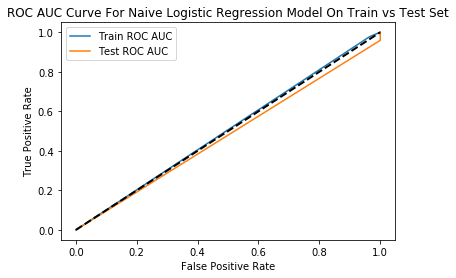

In [22]:
test_y_p_hat = logistic_regression_p.predict(x_p_test_sc3.astype(float))
train_p_fpr, train_p_tpr, train_p_thresholds = roc_curve(y_true=y_p_train, y_score=train_y_p_hat[:,1])
test_p_fpr, test_p_tpr, test_p_thresholds = roc_curve(y_true=y_p_test, y_score=y_pred_lr_p[:,1])
plt.plot(train_p_fpr, train_p_tpr, label = 'Train ROC AUC')
plt.plot(test_p_fpr, test_p_tpr, label = 'Test ROC AUC')
plt.plot([0, 1], [0, 1], color = 'black', linewidth = 2, linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC AUC Curve For Naive Logistic Regression Model On Train vs Test Set')
plt.show()

In [23]:
freg=f_regression(x_p_train_sc3, y_p_train)
p=freg[1]
print(p.round(3))

[0.372]


# LightGBM

Load the data

In [24]:
df2 = pd.read_parquet(os.path.join(cwd, 'data', 'shots.parquet'))
df2.drop(['match_id', 'statsbomb_id', 'statsbomb_team_id', 'player_id_statsbomb', 'competition_gender', 'team_name',
         'player_id', 'firstName', 'middleName', 'lastName', 'Name', 'dataset', 'wyscout_id', 'wyscout_team_id', 'team_id',
         'player_id_wyscout','competition_name','minute','shot_zone','competition_gender','match_week'], axis=1, inplace=True)
mask_penalty = (df2.shot_type_name=='penalty')
df_penalty = df2[mask_penalty].copy()
df_penalty.drop(['x','y','visible_angle','middle_angle','distance_to_goal','distance_visible_angle','log_distance_to_goal',
                 'assist_type', 'pass_switch', 'pass_cross', 'pass_cut_back','counter_attack', 'pass_height_name',
                 'pass_technique_name', 'shot_zone_number','shot_zone_player_number','fast_break', 'strong_foot',
                 'body_part_name','shot_type_name','smart_pass','carry_length','pass_end_x','pass_end_y',
                 'goalkeeper_x', 'goalkeeper_y','n_angle','area_goal','area_shot','shot_one_on_one','shot_open_goal',
                'under_pressure'], axis=1, inplace=True)
X_penalty = df_penalty.drop('goal', axis=1)
y_penalty = df_penalty.goal

Split into train, calibration and test datasets

In [25]:
X_penalty_train_lgbm, X_penalty_test_lgbm, y_penalty_train_lgbm, y_penalty_test_lgbm = train_test_split(X_penalty, y_penalty,
                                                                        train_size=0.8, random_state=42, stratify=y_penalty)

Clean data. Categories to numbers. Drop distance and angle measures as just want raw locations for my models.

In [26]:
def clean_lightgbm_p(df):
    df = df.copy()
    # replace categorical columns
    H_A_column_cat = {'Home Team': 0, 'Away Team': 1}
    match_moment_cat = {'0-15': 0, '15-30': 1, '30-45': 2, '45-60': 3, '60-75': 4, '75-90': 5}
    competition_type_cat = {'League': 0, 'Cup': 1}
    competition_part_cat = {'start': 0, 'middle': 1, 'final': 2, 'group': 3, 'knockout': 4}
    df.H_A_column.replace(H_A_column_cat, inplace=True)
    df.match_moment.replace(match_moment_cat, inplace=True)
    df.competition_type.replace(competition_type_cat, inplace=True)
    df.competition_part.replace(competition_part_cat, inplace=True)
    return df
    
X_penalty_train_lgbm = clean_lightgbm_p(X_penalty_train_lgbm)
X_penalty_test_lgbm = clean_lightgbm_p(X_penalty_test_lgbm)

Implementation of the model wiht a fitting of the nested 5-fold cross validation of the LGBM Classifier using Bayesian optimisation.

In [27]:
lgbm = CalibratedClassifierCV(LGBMClassifier(random_state=42), method='isotonic', cv=3)
lgbm_param_grid = {'base_estimator__min_child_samples': Integer(0, 200),
                   'base_estimator__num_leaves': Integer(2, 500),
                   'base_estimator__reg_lambda': Real(0, 1),
                   'base_estimator__reg_alpha': Real(0, 1),
                   'base_estimator__max_depth': Integer(0, 500)}

Nested resampling using skopt and prediction finding of the test shots after the implementation.

In [28]:
searchcv_lgbm_p = BayesSearchCV(estimator=lgbm,
                         n_iter=100,
                         search_spaces=lgbm_param_grid,
                         cv=5,
                         n_jobs=-1)
%time searchcv_lgbm_p.fit(X_penalty_train_lgbm, y_penalty_train_lgbm)
y_pred_lgbm_p = searchcv_lgbm_p.best_estimator_.predict_proba(X_penalty_test_lgbm)

Wall time: 6min 3s


In [29]:
perm_result_p = permutation_importance(searchcv_lgbm_p.best_estimator_, X_penalty_train_lgbm, y_penalty_train_lgbm,
                                       n_repeats=10, random_state=42)
df_perm_importance_p = pd.DataFrame({'Feature':X_penalty_train_lgbm.columns,
                                   'importance': perm_result_p.importances.mean(axis=1),
                                   'std_dev': perm_result_p.importances.std(axis=1)})
df_perm_importance_p.sort_values('importance', ascending=False, inplace=True)
df_perm_importance_p.reset_index(drop=True, inplace=True)
df_perm_importance_p

,Feature,importance,std_dev
0,competition_type,0.0,0.0
1,competition_part,0.0,0.0
2,H_A_column,0.0,0.0
3,match_moment,0.0,0.0
4,shot_number,0.0,0.0
5,shot_player_number,0.0,0.0
6,players,0.0,0.0
7,players_rival,0.0,0.0


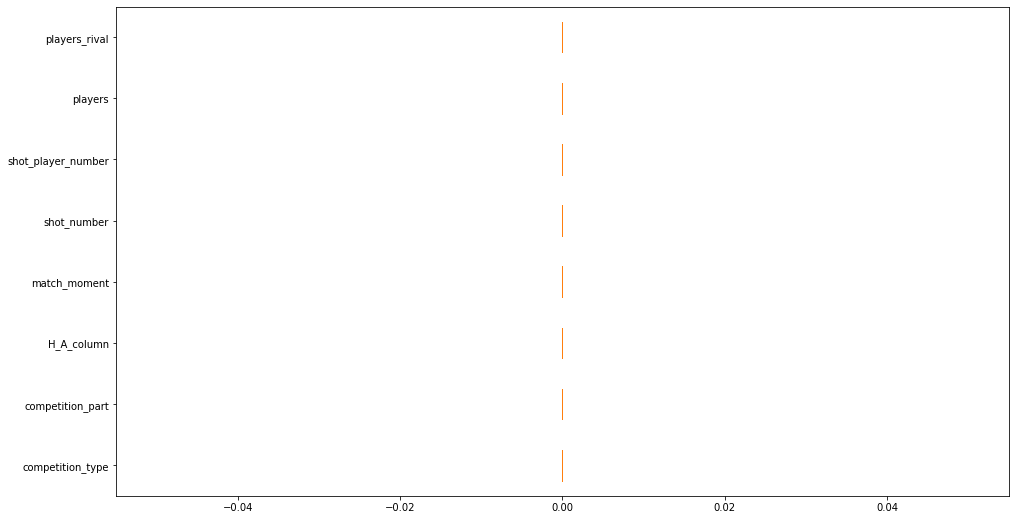

In [30]:
fig, ax = plt.subplots(figsize=(16, 9))
sorted_idx = perm_result_p.importances_mean.argsort()
bar_plot = ax.boxplot(perm_result_p.importances[sorted_idx].T, vert=False, labels=X_penalty_train_lgbm.columns[sorted_idx])

# XGBoost

Same process of splitting, adding data fake and cleaning of the LightGBM model.

In [31]:
df3 = pd.read_parquet(os.path.join(cwd, 'data', 'shots.parquet'))
df3.drop(['match_id', 'statsbomb_id', 'statsbomb_team_id', 'player_id_statsbomb', 'competition_gender', 'team_name',
         'player_id', 'firstName', 'middleName', 'lastName', 'Name', 'dataset', 'wyscout_id', 'wyscout_team_id', 'team_id',
         'player_id_wyscout','competition_name','minute','shot_zone','competition_gender','match_week'], axis=1, inplace=True)
mask_penalty = (df3.shot_type_name=='penalty')
df_penalty = df3[mask_penalty].copy()
df_penalty.drop(['x','y','visible_angle','middle_angle','distance_to_goal','distance_visible_angle','log_distance_to_goal',
                 'assist_type', 'pass_switch', 'pass_cross', 'pass_cut_back','counter_attack', 'pass_height_name',
                 'pass_technique_name', 'shot_zone_number','shot_zone_player_number','fast_break', 'strong_foot',
                 'body_part_name','shot_type_name','smart_pass','carry_length','pass_end_x','pass_end_y',
                 'goalkeeper_x', 'goalkeeper_y','n_angle','area_goal','area_shot','shot_one_on_one','shot_open_goal',
                'under_pressure'], axis=1, inplace=True)
X_penalty = df_penalty.drop('goal', axis=1)
y_penalty = df_penalty.goal

In [32]:
X_penalty_train_xgb, X_penalty_test_xgb, y_penalty_train_xgb, y_penalty_test_xgb = train_test_split(X_penalty, y_penalty,
                                                                        train_size=0.8, random_state=42, stratify=y_penalty)

In [33]:
def clean_lightgbm_p(df):
    df = df.copy()
    # replace categorical columns
    H_A_column_cat = {'Home Team': 0, 'Away Team': 1}
    match_moment_cat = {'0-15': 0, '15-30': 1, '30-45': 2, '45-60': 3, '60-75': 4, '75-90': 5}
    competition_type_cat = {'League': 0, 'Cup': 1}
    competition_part_cat = {'start': 0, 'middle': 1, 'final': 2, 'group': 3, 'knockout': 4}
    df.H_A_column.replace(H_A_column_cat, inplace=True)
    df.match_moment.replace(match_moment_cat, inplace=True)
    df.competition_type.replace(competition_type_cat, inplace=True)
    df.competition_part.replace(competition_part_cat, inplace=True)
    return df
    
X_penalty_train_xgb = clean_lightgbm_p(X_penalty_train_xgb)
X_penalty_test_xgb = clean_lightgbm_p(X_penalty_test_xgb)

Implementation of the model wiht a fitting of the nested 5-fold cross validation of the LGBM Classifier using Bayesian optimisation.

In [34]:
xgb = CalibratedClassifierCV(XGBClassifier(random_state=42, eval_metric='logloss'), method='isotonic', cv=3)
xgb_param_grid = {'base_estimator__min_child_weight': Integer(0, 50),
                   'base_estimator__reg_lambda': Real(0, 1),
                   'base_estimator__reg_alpha': Real(0, 1),
                   'base_estimator__max_depth': Integer(0, 10)}

Nested resampling using skopt and prediction finding of the test shots after the implementation.

In [35]:
searchcv_xgb_p = BayesSearchCV(estimator=xgb,
                             n_iter=100,
                             search_spaces=xgb_param_grid,
                             cv=5,
                             n_jobs=-1)
%time searchcv_xgb_p.fit(X_penalty_train_xgb, y_penalty_train_xgb)
y_pred_xgb_p = searchcv_xgb_p.best_estimator_.predict_proba(X_penalty_test_xgb)

Wall time: 5min 21s


In [36]:
perm_result_xgb_p = permutation_importance(searchcv_xgb_p.best_estimator_, X_penalty_train_xgb, y_penalty_train_xgb,
                                           n_repeats=10, random_state=42)
df_perm_importance_xgb_p = pd.DataFrame({'Feature':X_penalty_train_xgb.columns,
                                   'importance': perm_result_xgb_p.importances.mean(axis=1),
                                   'std_dev': perm_result_xgb_p.importances.std(axis=1)})
df_perm_importance_xgb_p.sort_values('importance', ascending=False, inplace=True)
df_perm_importance_xgb_p.reset_index(drop=True, inplace=True)
df_perm_importance_xgb_p

,Feature,importance,std_dev
0,shot_number,0.005183,0.001952
1,competition_part,0.004726,0.001438
2,H_A_column,0.001677,0.001266
3,match_moment,0.000152,0.001067
4,competition_type,0.000000,0.000000
5,players,0.000000,0.000000
6,players_rival,0.000000,0.000000
7,shot_player_number,-0.002439,0.002569


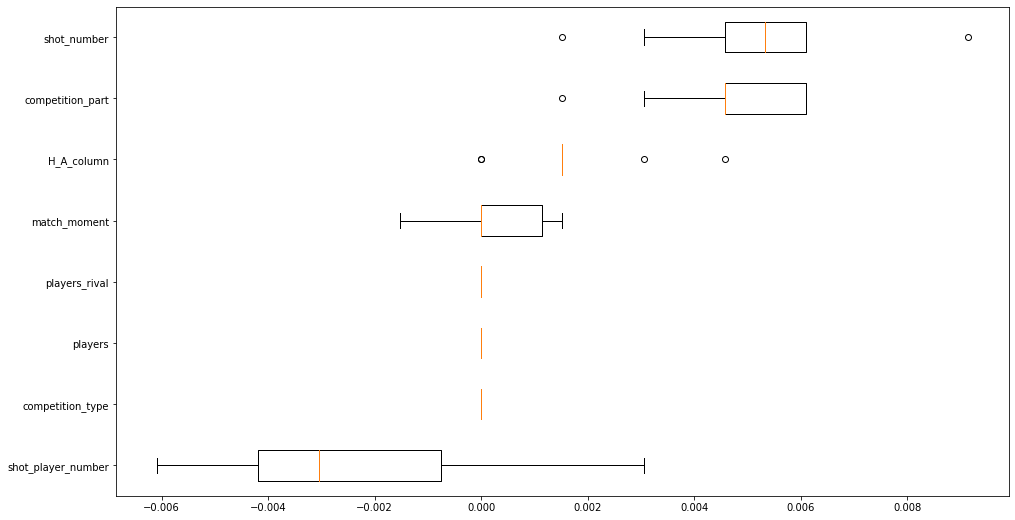

In [37]:
fig, ax = plt.subplots(figsize=(16, 9))
sorted_idx = perm_result_xgb_p.importances_mean.argsort()
bar_plot = ax.boxplot(perm_result_xgb_p.importances[sorted_idx].T, vert=False, labels=X_penalty_train_xgb.columns[sorted_idx])

# Random Forest

Same process of splitting and generation of dummy variables of the Logistic Regression model.

In [38]:
cwd = os.getcwd()
df4 = pd.read_parquet(os.path.join(cwd, 'data', 'shots.parquet'))
df4.drop(['match_id', 'statsbomb_id', 'statsbomb_team_id', 'player_id_statsbomb', 'competition_gender', 'team_name',
         'player_id', 'firstName', 'middleName', 'lastName', 'Name', 'dataset', 'wyscout_id', 'wyscout_team_id', 'team_id',
         'player_id_wyscout','competition_name','minute','shot_zone','match_week','pass_end_y',
         'goalkeeper_x', 'goalkeeper_y', 'carry_length', 'shot_one_on_one', 'shot_open_goal','under_pressure', 'area_shot', 
         'area_goal', 'n_angle', 'smart_pass','pass_end_x'], axis=1, inplace=True)
mask_penalty = (df4.shot_type_name=='penalty')
df_penalty_rf = df4[mask_penalty].copy()
df_penalty_rf.drop(['x','y','visible_angle','middle_angle','distance_to_goal','distance_visible_angle','log_distance_to_goal',
                 'assist_type', 'pass_switch', 'pass_cross', 'pass_cut_back','counter_attack', 'pass_height_name',
                 'pass_technique_name', 'shot_zone_number','shot_zone_player_number','fast_break', 'strong_foot',
                 'body_part_name','shot_type_name'], axis=1, inplace=True)

In [39]:
df_p_rf = pd.get_dummies(df_penalty_rf, columns=['competition_type','competition_part','H_A_column','match_moment'])
y_p_rf = df_p_rf['goal']
x_p_rf = df_p_rf.drop(['goal'], axis=1)
x_p_train_rf, x_p_test_rf, y_p_train_rf, y_p_test_rf = train_test_split(x_p_rf, y_p_rf, train_size=0.8, random_state=42,
                                                                    stratify=y_p_rf)

Implementation of the model wiht a fitting of the nested 5-fold cross validation of the LGBM Classifier using Bayesian optimisation.

In [40]:
rf = CalibratedClassifierCV(RandomForestClassifier(random_state=42), method='isotonic', cv=3)
rf_param_grid = {'base_estimator__n_estimators': [100, 500],
                   'base_estimator__max_features': ['auto'],
                   'base_estimator__min_samples_leaf': [1, 5, 20, 100],
                   'base_estimator__min_samples_split': [2, 10, 50, 250],
                   'base_estimator__criterion': ["gini", "entropy"],
                   'base_estimator__max_depth': [4, 6, 8, 10, None]
}

Nested resampling using skopt and prediction finding of the test shots after the implementation.

In [41]:
searchcv_rf_p = BayesSearchCV(estimator=rf,
                                 n_iter=100,
                                 search_spaces=rf_param_grid,
                                 cv=5,
                                 n_jobs=-1)
%time searchcv_rf_p.fit(x_p_train_rf, y_p_train_rf)
y_pred_rf_p = searchcv_rf_p.best_estimator_.predict_proba(x_p_test_rf)

Wall time: 12min 3s


In [42]:
perm_result_rf_p = permutation_importance(searchcv_rf_p.best_estimator_, x_p_train_rf, y_p_train_rf, n_repeats=10,
                                     random_state=42)
df_perm_importance_rf_p = pd.DataFrame({'Feature':x_p_train_rf.columns,
                                   'importance': perm_result_rf_p.importances.mean(axis=1),
                                   'std_dev': perm_result_rf_p.importances.std(axis=1)})
df_perm_importance_rf_p.sort_values('importance', ascending=False, inplace=True)
df_perm_importance_rf_p.reset_index(drop=True, inplace=True)
df_perm_importance_rf_p

,Feature,importance,std_dev
0,shot_number,0.020427,0.003064
1,shot_player_number,0.019817,0.002261
2,competition_part_final,0.017378,0.003354
3,H_A_column_Away Team,0.012348,0.001982
4,H_A_column_Home Team,0.011433,0.002073
5,match_moment_60-75,0.010366,0.001904
6,competition_part_middle,0.009909,0.002073
7,match_moment_30-45,0.008994,0.001982
8,match_moment_75-90,0.008841,0.002240
9,competition_part_start,0.008079,0.002266


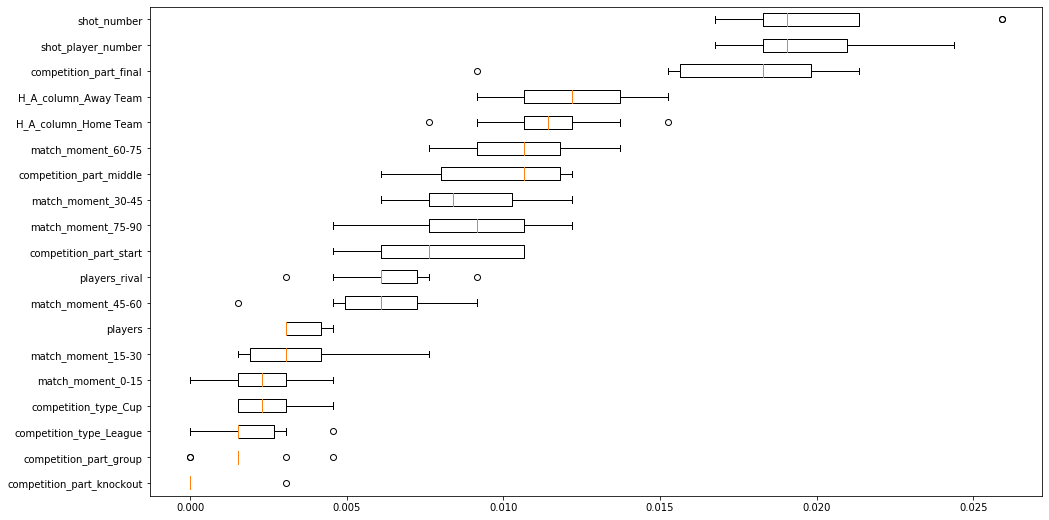

In [43]:
fig, ax = plt.subplots(figsize=(16, 9))
sorted_idx = perm_result_rf_p.importances_mean.argsort()
bar_plot = ax.boxplot(perm_result_rf_p.importances[sorted_idx].T, vert=False, labels=x_p_train_rf.columns[sorted_idx])

# Test

Calculate calibration curve on test data for penalty shots

In [44]:
# logistic regression
y_true_test_lr_p = y_p_test
fraction_of_positives_lr_p, mean_predicted_value_lr_p = calibration_curve(y_true_test_lr_p, y_pred_lr_p[:,1], n_bins=10,
                                                                      strategy='quantile')
# lightGBM
fraction_of_positives_lgbm_p, mean_predicted_value_lgbm_p = calibration_curve(y_penalty_test_lgbm, y_pred_lgbm_p[:, 1],
                                                                              n_bins=10, strategy='quantile')
# XGBoost
fraction_of_positives_xgb_p, mean_predicted_value_xgb_p = calibration_curve(y_penalty_test_xgb, y_pred_xgb_p[:, 1],
                                                                            n_bins=10, strategy='quantile')
# Random Forest
y_true_test_rf_p = y_p_test_rf
fraction_of_positives_rf_p, mean_predicted_value_rf_p = calibration_curve(y_true_test_rf_p, y_pred_rf_p[:,1], n_bins=10,
                                                                      strategy='quantile')

Text(0.5, 1.0, 'Distribution of predictions')

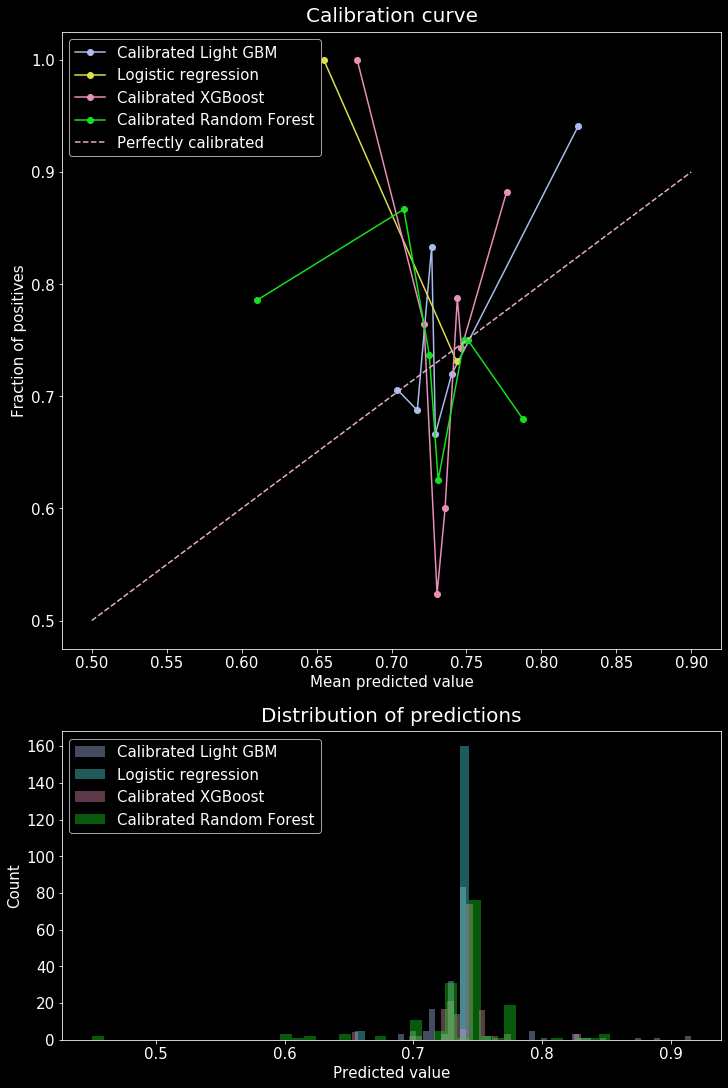

In [45]:
# Plot calibration curve on test data
plt.style.use('dark_background')
fig = plt.figure(constrained_layout=True, figsize=(10, 15))
gs = fig.add_gridspec(ncols=1, nrows=2, height_ratios=(2/3, 1/3))
ax1 = fig.add_subplot(gs[0])
ax1.plot(mean_predicted_value_lgbm_p, fraction_of_positives_lgbm_p, "-o", color='#aabced', label='Calibrated Light GBM')
ax1.plot(mean_predicted_value_lr_p, fraction_of_positives_lr_p, "-o", color='#dbdf4a', label='Logistic regression')
ax1.plot(mean_predicted_value_xgb_p, fraction_of_positives_xgb_p, "-o", color='#e88fb9', label='Calibrated XGBoost')
ax1.plot(mean_predicted_value_rf_p, fraction_of_positives_rf_p, "-o", color='#16e01d', label='Calibrated Random Forest')
ax1.plot([0.5, 0.9], [0.5, 0.9], "--", color='#e7aeca', label="Perfectly calibrated")
ax1.set_xlabel('Mean predicted value', fontsize=15)
ax1.set_ylabel('Fraction of positives', fontsize=15)
ax1.set_title('Calibration curve', fontsize=20, pad=10)
ax1.legend(fontsize=15)
ax1.tick_params(labelsize=15)
ax2 = fig.add_subplot(gs[1])
sns.distplot(y_pred_lgbm_p[:, 1], color='#aabced', label='Calibrated Light GBM', kde=False, ax=ax2)
sns.distplot(y_pred_lr_p[:,1], color='#4fe4e4', label='Logistic regression', kde=False, ax=ax2)
sns.distplot(y_pred_xgb_p[:, 1], color='#e88fb9', label='Calibrated XGBoost', kde=False, ax=ax2)
sns.distplot(y_pred_rf_p[:, 1], color='#16e01d', label='Calibrated Random Forest', kde=False, ax=ax2)
ax2.set_xlabel('Predicted value', fontsize=15)
ax2.set_ylabel('Count', fontsize=15)
ax2.tick_params(labelsize=15)
ax2.legend(fontsize=15)
ax2.set_title('Distribution of predictions', fontsize=20, pad=10)

In [46]:
# logistic regression
y_true_test_lr_p = y_p_test
fraction_of_positives_lr_p, mean_predicted_value_lr_p = calibration_curve(y_true_test_lr_p, y_pred_lr_p[:,1], n_bins=10,
                                                                      strategy='uniform')
# lightGBM
fraction_of_positives_lgbm_p, mean_predicted_value_lgbm_p = calibration_curve(y_penalty_test_lgbm, y_pred_lgbm_p[:, 1],
                                                                              n_bins=10, strategy='uniform')
# XGBoost
fraction_of_positives_xgb_p, mean_predicted_value_xgb_p = calibration_curve(y_penalty_test_xgb, y_pred_xgb_p[:, 1],
                                                                            n_bins=10, strategy='uniform')
# Random Forest
y_true_test_rf_p = y_p_test_rf
fraction_of_positives_rf_p, mean_predicted_value_rf_p = calibration_curve(y_true_test_rf_p, y_pred_rf_p[:,1], n_bins=10,
                                                                      strategy='uniform')

Text(0.5, 1.0, 'Distribution of predictions')

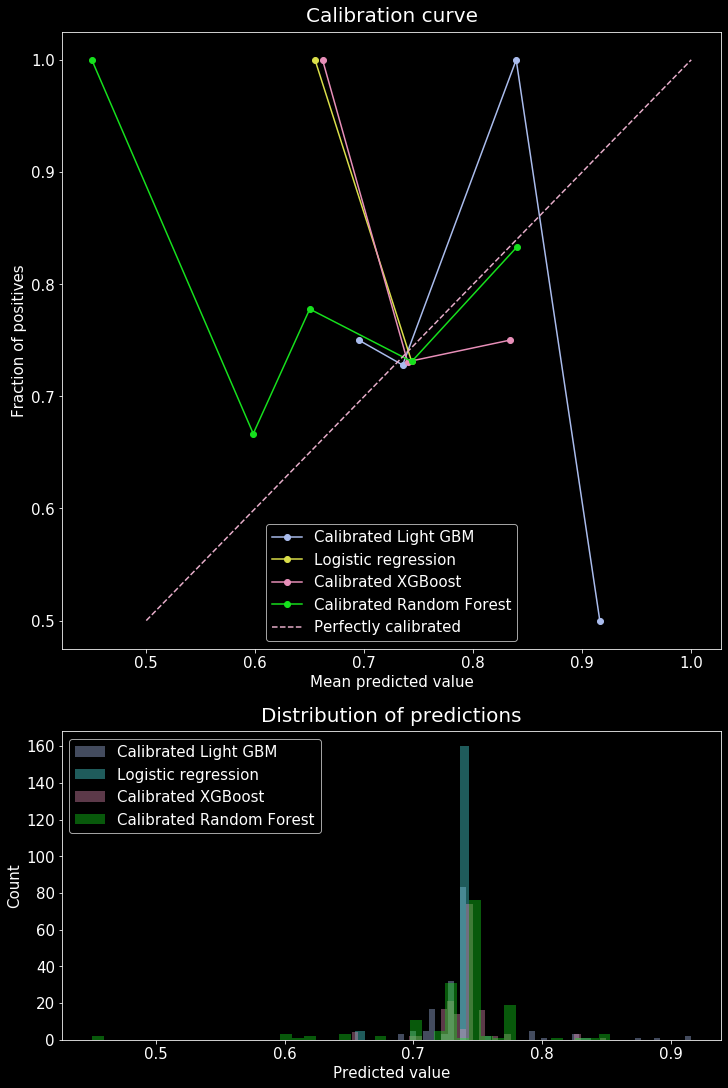

In [47]:
# Plot calibration curve on test data
fig = plt.figure(constrained_layout=True, figsize=(10, 15))
gs = fig.add_gridspec(ncols=1, nrows=2, height_ratios=(2/3, 1/3))
ax1 = fig.add_subplot(gs[0])
ax1.plot(mean_predicted_value_lgbm_p, fraction_of_positives_lgbm_p, "-o", color='#aabced', label='Calibrated Light GBM')
ax1.plot(mean_predicted_value_lr_p, fraction_of_positives_lr_p, "-o", color='#dbdf4a', label='Logistic regression')
ax1.plot(mean_predicted_value_xgb_p, fraction_of_positives_xgb_p, "-o", color='#e88fb9', label='Calibrated XGBoost')
ax1.plot(mean_predicted_value_rf_p, fraction_of_positives_rf_p, "-o", color='#16e01d', label='Calibrated Random Forest')
ax1.plot([0.5, 1], [0.5, 1], "--", color='#e7aeca', label="Perfectly calibrated")
ax1.set_xlabel('Mean predicted value', fontsize=15)
ax1.set_ylabel('Fraction of positives', fontsize=15)
ax1.set_title('Calibration curve', fontsize=20, pad=10)
ax1.legend(fontsize=15)
ax1.tick_params(labelsize=15)
ax2 = fig.add_subplot(gs[1])
sns.distplot(y_pred_lgbm_p[:, 1], color='#aabced', label='Calibrated Light GBM', kde=False, ax=ax2)
sns.distplot(y_pred_lr_p[:,1], color='#4fe4e4', label='Logistic regression', kde=False, ax=ax2)
sns.distplot(y_pred_xgb_p[:, 1], color='#e88fb9', label='Calibrated XGBoost', kde=False, ax=ax2)
sns.distplot(y_pred_rf_p[:, 1], color='#16e01d', label='Calibrated Random Forest', kde=False, ax=ax2)
ax2.set_xlabel('Predicted value', fontsize=15)
ax2.set_ylabel('Count', fontsize=15)
ax2.tick_params(labelsize=15)
ax2.legend(fontsize=15)
ax2.set_title('Distribution of predictions', fontsize=20, pad=10)

In [48]:
print("The log loss of the penalty model with Logistic Regresion is: " + str(log_loss(y_true_test_lr_p, y_pred_lr_p[:,1])))
print("The ROC AUC score of the penalty model with Logistic Regresion is: " +str(roc_auc_score(y_true_test_lr_p,
                                                                                               y_pred_lr_p[:,1])))
print('The McFaddens Pseudo R-squared of the penalty model with Logistic Regresion is:', mcfadden_r2(y_true_test_lr_p,
                                                                                                y_pred_lr_p[:,1]))
print('The Brier score of the penalty model with Logistic Regresion is:',brier_score_loss(y_true_test_lr_p, y_pred_lr_p[:,1],
                                                                         pos_label=y_true_test_lr_p.max()))

The log loss of the penalty model with Logistic Regresion is: 0.5775764872397784
The ROC AUC score of the penalty model with Logistic Regresion is: 0.47950819672131145
The McFaddens Pseudo R-squared of the penalty model with Logistic Regresion is: -0.006774747037232576
The Brier score of the penalty model with Logistic Regresion is: 0.19432202819252753


In [49]:
print("The log loss of the penalty model with LightGBM is: " + str(log_loss(y_penalty_test_lgbm, y_pred_lgbm_p)))
print("The ROC AUC score of the penalty model with LightGBM is: " +str(roc_auc_score(y_penalty_test_lgbm,
                                                                                  y_pred_lgbm_p[:,1])))
print('The McFaddens Pseudo R-squared of the penalty model with LightGBM is:', mcfadden_r2(y_penalty_test_lgbm,
                                                                                                     y_pred_lgbm_p[:,1]))
print('The Brier score of the penalty model with LightGBM is:',brier_score_loss(y_penalty_test_lgbm, y_pred_lgbm_p[:,1], 
                                                           pos_label=y_penalty_test_lgbm.max()))

The log loss of the penalty model with LightGBM is: 0.5704753859740276
The ROC AUC score of the penalty model with LightGBM is: 0.5530880670987419
The McFaddens Pseudo R-squared of the penalty model with LightGBM is: 0.005603196990021542
The Brier score of the penalty model with LightGBM is: 0.19112861185674887


In [50]:
print("The log loss of the penalty model with XGBoost is: " + str(log_loss(y_penalty_test_xgb, y_pred_xgb_p)))
print("The ROC AUC score of the penalty model with XGBoost is: " +str(roc_auc_score(y_penalty_test_xgb, 
                                                                                  y_pred_xgb_p[:,1])))
print('The McFaddens Pseudo R-squared of the penalty model with XGBoost is:', mcfadden_r2(y_penalty_test_xgb,
                                                                                           y_pred_xgb_p[:,1]))
print('The Brier score of the penalty model with XGBoost is:',brier_score_loss(y_penalty_test_xgb, y_pred_xgb_p[:,1], 
                                                           pos_label=y_penalty_test_xgb.max()))

The log loss of the penalty model with XGBoost is: 0.575121856001579
The ROC AUC score of the penalty model with XGBoost is: 0.5540411742279832
The McFaddens Pseudo R-squared of the penalty model with XGBoost is: -0.0024960743445161526
The Brier score of the penalty model with XGBoost is: 0.19338462504816534


In [51]:
print("The log loss of the non-penalty model with Random Forest is: " + str(log_loss(y_true_test_rf_p, y_pred_rf_p)))
print("The ROC AUC score of the non-penalty model with Random Forest is: " +str(roc_auc_score(y_true_test_rf_p,
                                                                                             y_pred_rf_p[:,1])))
print('The McFaddens Pseudo R-squared of the non-penalty model with Random Forest is:', mcfadden_r2(y_true_test_rf_p,
                                                                                                   y_pred_rf_p[:,1]))
print('The Brier score of the non-penalty model with Random Forest is:',brier_score_loss(y_true_test_rf_p, y_pred_rf_p[:,1],
                                                                                    pos_label=y_true_test_rf_p.max()))

The log loss of the non-penalty model with Random Forest is: 0.5852911994631395
The ROC AUC score of the non-penalty model with Random Forest is: 0.4668318719024019
The McFaddens Pseudo R-squared of the non-penalty model with Random Forest is: -0.020222277569954983
The Brier score of the non-penalty model with Random Forest is: 0.19770836099336453


# Save models

In [52]:
dump(logistic_regression_p, os.path.join(cwd, 'models', 'lr_model_penalty.joblib'))

['C:\\Users\\sergi77\\Desktop\\UNIR\\TFM\\xG_Model_TFM\\models\\lr_model_penalty.joblib']

In [53]:
dump(searchcv_lgbm_p.best_estimator_, os.path.join(cwd, 'models', 'lgbm_model_penalty.joblib'))

['C:\\Users\\sergi77\\Desktop\\UNIR\\TFM\\xG_Model_TFM\\models\\lgbm_model_penalty.joblib']

In [54]:
dump(searchcv_xgb_p.best_estimator_, os.path.join(cwd, 'models', 'xgb_model_penalty.joblib'))

['C:\\Users\\sergi77\\Desktop\\UNIR\\TFM\\xG_Model_TFM\\models\\xgb_model_penalty.joblib']

In [55]:
dump(searchcv_rf_p.best_estimator_, os.path.join(cwd, 'models', 'rf_model_penalty.joblib'))

['C:\\Users\\sergi77\\Desktop\\UNIR\\TFM\\xG_Model_TFM\\models\\rf_model_penalty.joblib']

# Save data

In [56]:
# reload shot dataset for ids
df = pd.read_parquet(os.path.join(cwd, 'data', 'shots.parquet'))
df = df[['match_id', 'wyscout_id', 'statsbomb_id']].copy()

In [57]:
x_p_train3['goal'] = y_p_train
x_p_train3['split'] = 'train'
x_p_test3['goal'] = y_p_test
x_p_test3['split'] = 'test'
df_penalty = pd.concat([x_p_train3, x_p_test3])
df_penalty = df_penalty.merge(df, left_index=True, right_index=True, validate='1:1', how='left')
df_penalty.reset_index(drop=True, inplace=True)
df_penalty.to_parquet(os.path.join(cwd, 'data', 'modelling', 'lr_penalty.parquet'))

In [58]:
# reload shot dataset for ids
df2 = pd.read_parquet(os.path.join(cwd, 'data', 'shots.parquet'))
mask_penalty = (df2.shot_type_name=='penalty')
df_penalty2 = df2[mask_penalty].copy()
df_penalty2 = df_penalty2[['match_id', 'wyscout_id', 'statsbomb_id']].copy()

In [59]:
X_penalty_train_lgbm['goal'] = y_penalty_train_lgbm
X_penalty_train_lgbm['split'] = 'train'
X_penalty_test_lgbm['goal'] = y_penalty_test_lgbm
X_penalty_test_lgbm['split'] = 'test'
df_lgbm_penalty = pd.concat([X_penalty_train_lgbm, X_penalty_test_lgbm])
df_lgbm_penalty = df_lgbm_penalty[df_lgbm_penalty.index.isin(df_penalty2.index)].copy()
df_lgbm_penalty = df_lgbm_penalty.merge(df_penalty2, how='left', left_index=True, right_index=True, validate='1:1')
df_lgbm_penalty.to_parquet(os.path.join(cwd, 'data', 'modelling', 'lgbm_penalty.parquet'))

In [60]:
df3 = pd.read_parquet(os.path.join(cwd, 'data', 'shots.parquet'))
mask_penalty = (df3.shot_type_name=='penalty')
df_penalty3 = df3[mask_penalty].copy()
df_penalty3 = df_penalty3[['match_id', 'wyscout_id', 'statsbomb_id']].copy()

In [61]:
X_penalty_train_xgb['goal'] = y_penalty_train_xgb
X_penalty_train_xgb['split'] = 'train'
X_penalty_test_xgb['goal'] = y_penalty_train_xgb
X_penalty_test_xgb['split'] = 'test'
df_lgbm_penalty = pd.concat([X_penalty_train_xgb, X_penalty_test_xgb])
df_lgbm_penalty = df_lgbm_penalty[df_penalty3.index.isin(df_penalty.index)].copy()
df_lgbm_penalty = df_lgbm_penalty.merge(df_penalty3, how='left', left_index=True, right_index=True, validate='1:1')
df_lgbm_penalty.to_parquet(os.path.join(cwd, 'data', 'modelling', 'xgb_penalty.parquet'))

In [62]:
# reload shot dataset for ids
df4 = pd.read_parquet(os.path.join(cwd, 'data', 'shots.parquet'))
df4 = df4[['match_id', 'wyscout_id', 'statsbomb_id']].copy()

In [63]:
x_p_train_rf['goal'] = y_p_train_rf
x_p_train_rf['split'] = 'train'
x_p_test_rf['goal'] = y_p_test_rf
x_p_test_rf['split'] = 'test'
df_penalty4 = pd.concat([x_p_train_rf, x_p_test_rf])
df_penalty4 = df_penalty4.merge(df4, left_index=True, right_index=True, validate='1:1', how='left')
df_penalty4.reset_index(drop=True, inplace=True)
df_penalty4.to_parquet(os.path.join(cwd, 'data', 'modelling', 'rf_penalty.parquet'))